In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import math
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import sys
import os
import socket
#import lmod
# lmod.load('system')
# lmod.load('texlive')
# lmod.
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
import hpc_reports
#
# def running_mean(X,n=10):
#     return (numpy.cumsum(numpy.insert(X,0,0))[n:] - numpy.cumsum(numpy.insert(X,0,0))[:-n])/n
# #

In [3]:
n_cpus = 4
print('** epoch: {}'.format(mpd.get_epoch()))


** epoch: 1970-01-01T00:00:00


In [4]:
N_report_len = 180
end_dtm = dtm.datetime(2022,7,6)
end_date = end_dtm.date()
start_date = end_date - dtm.timedelta(days=N_report_len)
print('*** dates: {} - {}'.format(start_date, end_date))
partition='serc'
#partition=None
group=None
s_user=None
verbose=0
# group='oneillm'
# group='edunham'
#s_user = 'labraha2'
#
sacct_h5_file = f'sacct_data/sacct_p{str(partition).upper()}_g{str(group).upper()}_u{s_user}_{start_date.year:04}{start_date.month:02}{start_date.day:02}_{end_dtm.year:04}{end_dtm.month:02}{end_dtm.day:02}.h5'
print(f'*** sacct_h5_file: {sacct_h5_file}')

*** dates: 2022-01-07 - 2022-07-06
*** sacct_h5_file: sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5


In [5]:
# NOTE: to get individual users, eg to get Eric's group usage:
#. sacct --allusers --user=labraha2 --start=2022-01-01 --end=2022-06-15
#
# NOTE: additional options can be passed in the more_options=[] arrary, or just as sacct_{option-name}={val}
#
if os.path.isfile(sacct_h5_file):
    print('*** Creating SACCT object from HDF5 {}'.format(sacct_h5_file))
    SACCT_obj = hpc_lib.SACCT_data_from_h5(sacct_h5_file, keep_raw_data=False, n_cpu=n_cpus)
    #
    
else:
    print('*** Fetching SACCT data directly')
    SACCT_obj = hpc_lib.SACCT_data_direct(group=group, partition=partition, start_date=str(start_date),
                                          n_cpu=n_cpus, verbose=verbose,
                                          end_date=str(end_date), keep_raw_data=False)
    # , sacct_user=s_user
    print(f'** writing HDF5: {sacct_h5_file}')
    SACCT_obj.write_hdf5(sacct_h5_file)
    #
#
print('** ', SACCT_obj.jobs_summary.dtype.names)

*** Creating SACCT object from HDF5 sacct_data/sacct_pSERC_gNONE_uNone_20220107_20220706.h5
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqTRES', 'AllocTRES', 'MaxRSS', 'AveRSS', 'AveVMSize', 'MaxVMSize', 'MaxDiskWrite', 'MaxDiskRead', 'AveDiskWrite', 'AveDiskRead', 'JobID_parent')


In [ ]:
# # check date epoch:
# dt_test = SACCT_obj.jobs_summary['Start'][0]
# yr_test = mpd.num2date(dt_test).year
# print(f'** yr_test: {yr_test}')
# #print('** ', mpd.num2epoch(dt_test))
# if yr_test>3000:
#     mpd.set_epoch('0000-12-31T00:00:00')
# yr_test = mpd.num2date(dt_test)
# print(f'** yr_test: {yr_test}')

In [6]:
cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group')

### CPU-Hours, Jobs layer cake + Pie charts.
- Fist, the semi-manual construction. Uses some consolidated functions (eg, _layer_cake() and plot_pie() )
- Then, these all wrapped up into one line or data + figures setup, then one line.

/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


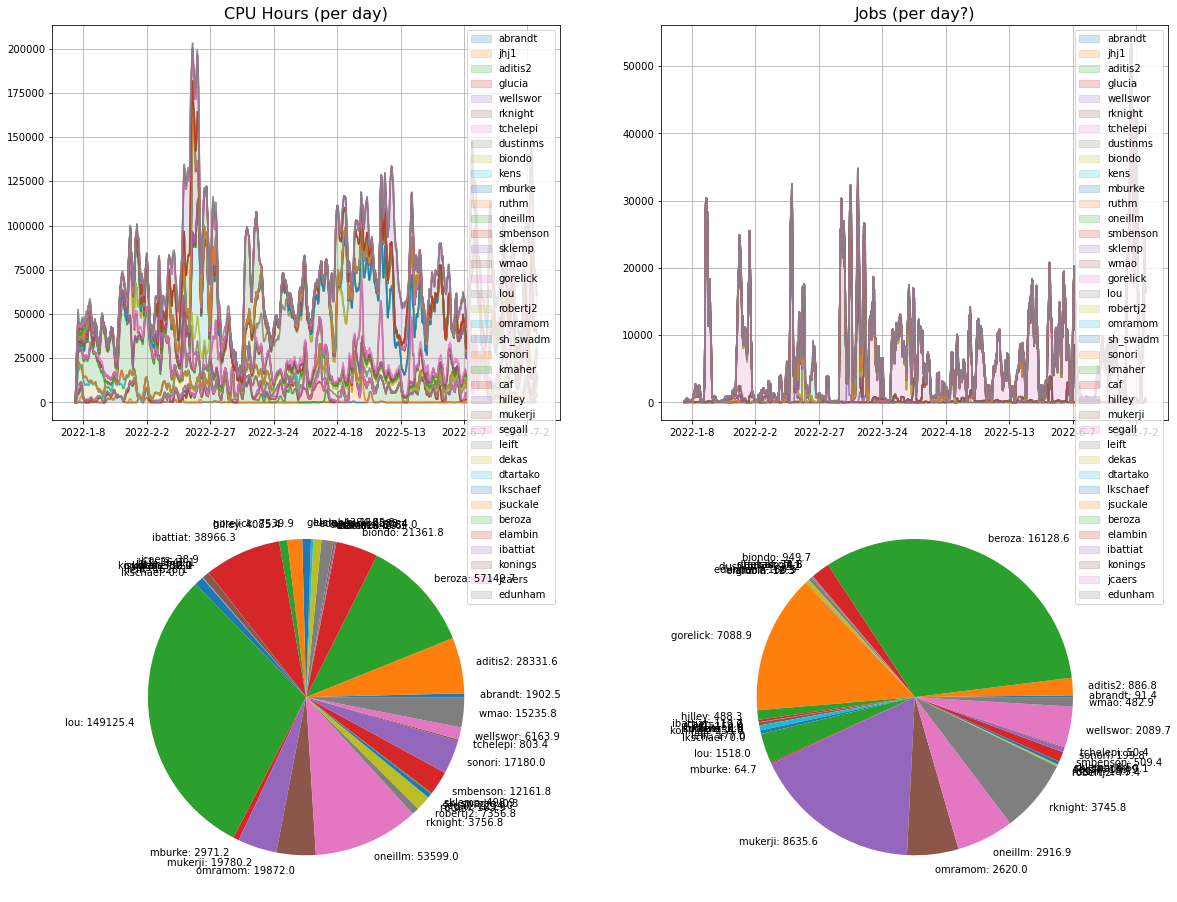

In [7]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
#cpuh_layers = SACCT_obj.get_cpu_hours_layer_cake(bin_size=1., layer_field='Group')
group_by = 'Group'
cpuh = cpuh_layers['cpu_hours']
jobs = cpuh_layers['jobs']
T = cpuh['time']
#
z_cpuh = hpc_lib.plot_layer_cake(data=cpuh, layers=cpuh.dtype.names[1:], time_col='time', ax=ax1)
z_jobs = hpc_lib.plot_layer_cake(data=jobs, layers=cpuh.dtype.names[1:], time_col='time', ax=ax2)
#
pie_cpuh_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed']*SACCT_obj['NCPUS'],
                                slice_data=SACCT_obj[group_by], ax=ax3
                                )
#pi_slices = ax.pie(pi_slices[:,1], labels=pi_slices[:,0])
pie_jobs_data = hpc_lib.plot_pie(sum_data=SACCT_obj['Elapsed'], slice_data=SACCT_obj[group_by], 
                            ax=ax4)
#
ax1.legend(loc=0)
ax2.legend(loc=0)
#


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(lbls)


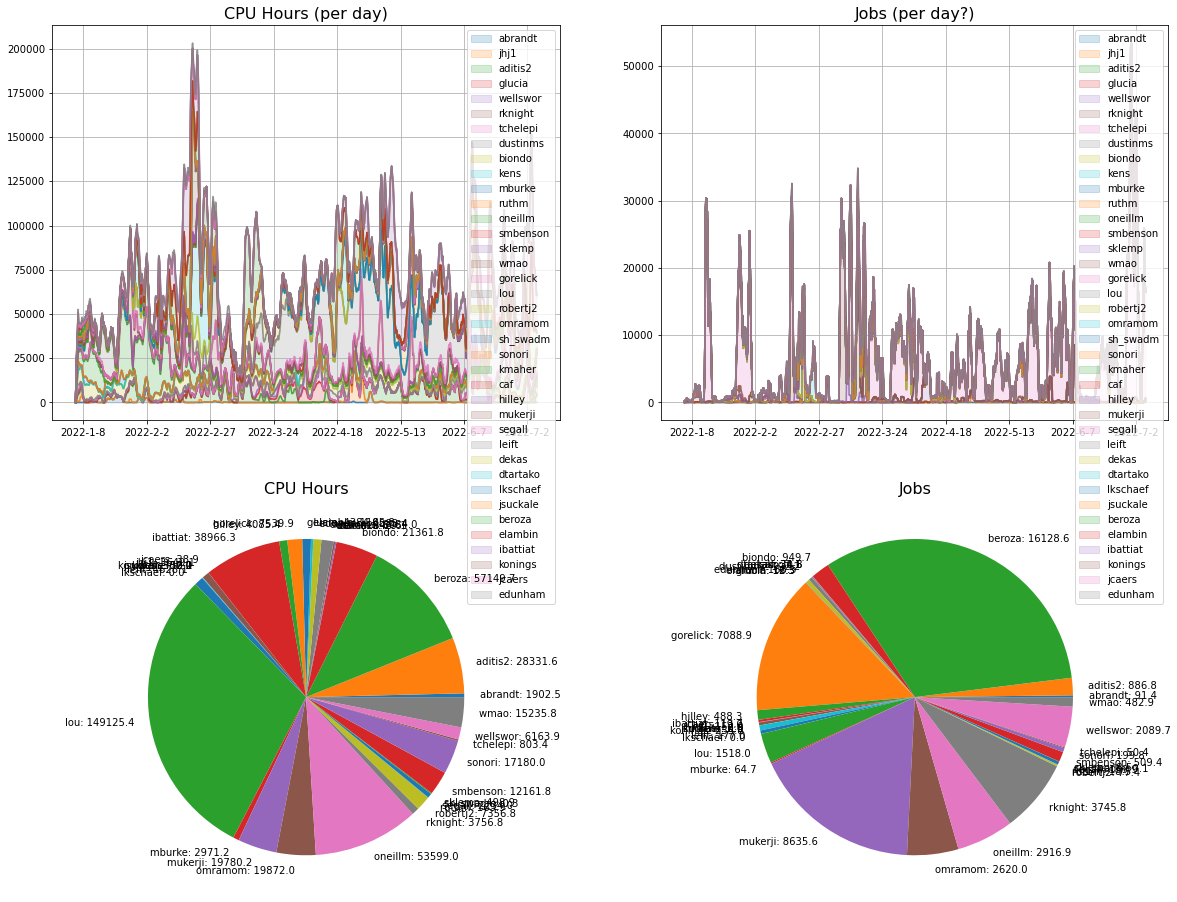

In [9]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)

zz = SACCT_obj.report_cpuhours_jobs_layercake_and_pie(fg=fg, cpuh_jobs=cpuh_layers)

In [10]:
dt_ep = hpc_lib.compute_mpd_epoch_dt(738150)
print('** ', dt_ep)
print('** ', SACCT_obj.compute_mpd_epoch_dt())
print('** *', hpc_lib.compute_mpd_epoch_dt(dtm.datetime.now()))
#
#print('** ', isinstance(numpy.datetime64(dtm.datetime.now())) )

**  -719163.0
**  0.0
** * 0.0


In [11]:
acpu_layer_cake = SACCT_obj.get_active_cpus_layer_cake(layer_field='Group')

*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [19048.34990741] [19050.21159722]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
** ** **: t_start, t_end:  [19157.59607639] [19157.59704861]
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None
*** DEBUG: 5000, None


In [50]:
print('*** ', SACCT_obj.dt_mpd_epoch)
print('*** ', mpd.date2num(dtm.datetime.now()), numpy.min(SACCT_obj['Start']))

***  0.0
***  19188.62718520331 18993.88241898148


*** DEBUG t_now: 19188.641932581828, t_max: 19179.504652777778


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ln, = ax.plot(T,z, ls='-', alpha=.8)
/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:3145: UserWarning: FixedFormatter should only be used together with FixedLocator
  ln, = ax.plot(T,z, ls='-', alpha=.8)


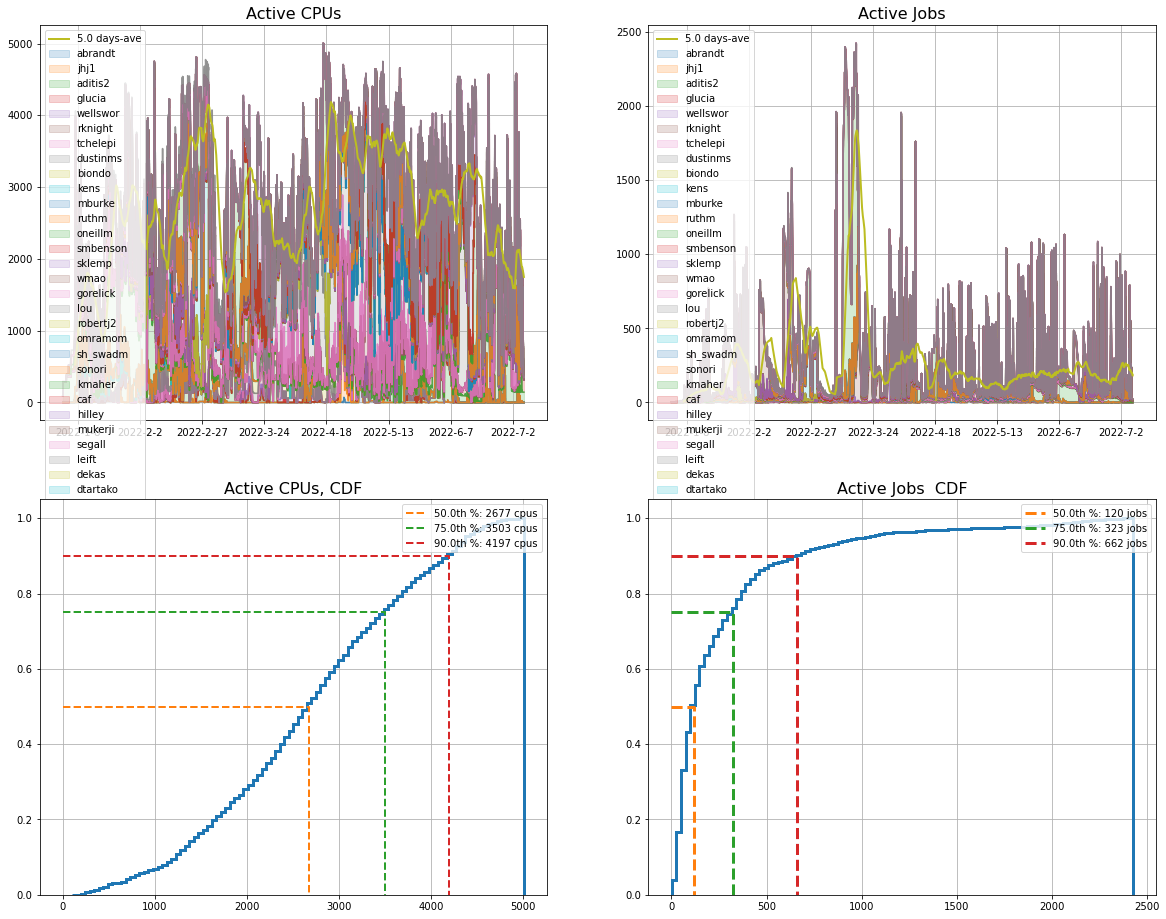

In [53]:
qq = SACCT_obj.report_activecpus_jobs_layercake_and_CDFs(n_points=5000,
                        group_by='Group', acpu_layer_cake=None)
# acpu_layer_cake


In [41]:
ZZ = numpy.array([SACCT_obj['Start'], SACCT_obj['End']])

print('*** ', len(ZZ.ravel()) )


#print('** ', numpy.nanmin([SACCT_obj['Start'], SACCT_obj['End'], mpd.date2num(dtm.datetime.now())] ))

***  2388464


In [ ]:
zz = SACCT_obj.active_cpu_jobs_per_day_hour_report()

In [ ]:
print('*** ', mpd.num2date(738150))
print('*** ', mpd.date2num(dtm.datetime(2022,1,1)))
print('*** ', 3600/24)
#
print('** ', SACCT_obj.jobs_summary.dtype.descr)
print('** cpu_hours capacity: ', 350*24*24)
print('** quantiles_cpu: ', qs_cpus)

In [ ]:
fg = plt.figure(figsize=(20,16))
ax1 = fg.add_subplot(2,2,1)
ax2 = fg.add_subplot(2,2,2)
ax3 = fg.add_subplot(2,2,3)
ax4 = fg.add_subplot(2,2,4)
ax1.grid()
ax2.grid()
#
ax1.set_title('CPU Hours (per day)', size=16)
ax2.set_title('Jobs (per day?)', size=16)
#
cpuh = cpuh_layers['cpu_hours']
hpc_lib.plot_layer_cake(data=cpuh_layers['cpu_hours'], ax=ax1)
hpc_lib.plot_layer_cake(data=cpuh_layers['jobs'], ax=ax2)

ax3.plot(cpuh['time'], cpuh['tgp'])

In [ ]:
NGPUS = [s.split('gpu=')[1].split(',')[0] if 'gpu=' in s else 0 
         for s in SACCT_obj.jobs_summary['AllocTRES'].astype(str)]

In [ ]:
plt.plot(SACCT_obj.get_NGPUs())

### Mazama GPU activity

In [ ]:
maz_h5 = 'sacct_data/sacct_pNONE_gNONE_uNone_20211222_20220620.h5'
SACCT_serc = SACCT_obj = hpc_lib.SACCT_data_from_h5(maz_h5, keep_raw_data=False, n_cpu=n_cpus)

# serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
#                                                NCPUs=SACCT_serc.get_NGPUs())

In [ ]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

In [ ]:
# For MAZAMA
#
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)

### SERC GPU activity

In [ ]:
serc_h5 = 'sacct_data/serc_sacct_20211126_20220525.h5'
SACCT_serc = hpc_lib.SACCT_data_from_h5(serc_h5, keep_raw_data=False, n_cpu=n_cpus)

serc_gpu_activity = SACCT_serc.active_jobs_cpu(jobs_summary=None, bin_size=1., 
                                               NCPUs=SACCT_serc.get_NGPUs())

In [ ]:
gpu_layers = SACCT_serc.get_active_cpus_layer_cake(layer_field='Group', NCPUs=SACCT_serc.get_NGPUs())

In [ ]:
pi_gpu_grps = [s for s in gpu_layers['N_cpu'].dtype.names[1:]]
print(f'** {pi_gpu_lbls}' )
#
NGPU = SACCT_serc.get_NGPUs()
#
#pi_gpu_vals = numpy.zeros(len(pi_gpu_lbls))
pi_gpu_vals = []
pi_gpu_lbls = []
for k,g in enumerate(pi_gpu_grps):
    ix = SACCT_serc.jobs_summary['Group'].astype(str)==g
    #
    n_gpus = numpy.sum(SACCT_serc.jobs_summary['Elapsed'][ix] * NGPU[ix])
    if n_gpus <= 0.:
        continue
    #
    pi_gpu_vals += [n_gpus]
    pi_gpu_lbls += [f'{g}: {pi_gpu_vals[-1]:.1f}']
#
print('** vals: ', pi_gpu_vals)
#pi_gpu_lbls = [f'{s}: {v:.1f}' for s,v in zip(pi_gpu_lbls, pi_gpu_vals) ]


fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(2,1,1)
ax2 = fg.add_subplot(2,2,3)
ax3 = fg.add_subplot(2,2,4)
ax1.grid()
#ax2.grid()
ax3.grid()
#
hpc_lib.plot_layer_cake(gpu_layers['N_cpu'], ax=ax1)
z_gpus = ax1.lines[-1].get_ydata()
qs = [.5, .75, .9]
qs_gpu = numpy.quantile(z_gpus, qs)
#
print('*** keys(): ', gpu_layers.keys())
ax2.pie(pi_gpu_vals, labels=pi_gpu_lbls) 
ax2.legend(loc=0)
#
hh_cpus = ax3.hist(z_gpus, bins=100, cumulative=True, density=True, histtype='step', lw=3.)
for x,y in zip(qs_gpu, qs):
    #ax3.plot([0., qs_cpus[-1], qs_cpus[-1]], [qs[-1], qs[-1], 0.], ls='--', color='r', lw=2. )
    ax3.plot([0., x, x], [y, y, 0.], ls='--', lw=2., label=f'{y*100.}th %: {x:.0f} gpus' )

ax1.set_title('Active GPUs', size=16)
ax3.legend(loc=0)


In [ ]:
print('** ', gpu_layers['N_cpu'].dtype.names)

In [ ]:
cpu_jobs_serc = SACCT_serc.active_jobs_cpu()


In [ ]:
serc_cpu_qs = numpy.quantile(cpu_jobs_serc['N_cpu'], [.5, .75, .9])
print('** qs: ', serc_cpu_qs)

In [ ]:
acpu = acpu_layer_cake['N_cpu']
fg = plt.figure(figsize=(18,16))
ax1 = fg.add_subplot(1,1,1)
#
ax1.grid()
ax1.plot(acpu['time'], acpu['tgp'])

fg.canvas.draw()
#lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) - hpc_lib.dt_mpd_epoch) ) 
#         for s in ax1.get_xticklabels()]
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(hpc_lib.fix_to_ascii(str(s.get_text()))) + SACCT_obj.dt_mpd_epoch) ) 
         for s in ax1.get_xticklabels()]
ax1.set_xticklabels(lbls)


In [ ]:
print('*** ', SACCT_serc.jobs_summary.dtype)

In [ ]:
print('*** ', hpc_lib.kmg_to_num('105k'))
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11k', '11m', '11M', '11g']])
print('** ', [hpc_lib.kmg_to_num(s) for s in ['11', '11.3', '', 's']])

In [ ]:
print('** ', SACCT_obj.jobs_summary.dtype.names)

In [ ]:
fg = plt.figure(figsize=(13,8))
ax = fg.add_subplot(1,1,1)
#
print('** ', numpy.sum([not numpy.isnan(x) for x in SACCT_obj.jobs_summary['MaxRSS']]))
hh = ax.hist(SACCT_obj.jobs_summary['MaxRSS'], bins=100, histtype='step', cumulative=True)

In [ ]:
os.system('hostname')

In [ ]:
import socket
socket.gethostname()